In [1]:
initial_path = 'peptide-QML/'
# initial_path = '../'

In [2]:
day = "0807"
name_notebook = day + "-sh_e_1qm.ipynb"

#ask the user if that is correct, if he says yes kkep going, otherwise stop
import sys
answer = input("{} is the name of the notebook | Is that correct? (y/n): ".format(name_notebook))
if answer != "y":
    print("Please, change the name of the notebook")
    sys.exit()

In [3]:
import numpy as np

In [4]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

# Data

In [5]:
data_file_path = initial_path + 'data/Scores/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(data_file_path)
score_list = np.array(number_list)/1000
vector_list = np.array([f.string_to_numbers
(string) for string in string_list]) # one hot encoding

In [6]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

In [7]:
# Define the dataset
input_data = ptm.torch.tensor(X) 
target_data = ptm.torch.tensor(Y).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation)
target_validation = ptm.torch.tensor(Y_validation).view(-1, 1)

In [8]:
input_data.shape, target_data.shape, input_validation.shape, target_validation.shape

(torch.Size([9000, 4]),
 torch.Size([9000, 1]),
 torch.Size([1000, 4]),
 torch.Size([1000, 1]))

# Quantum node

In [9]:
n_aminoacids = len(string_list[0])

In [10]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = qn.parts.AngleEmbedding, 
    embedding_ansatz = qn.parts.Ansatz_11,
    block_ansatz = qn.parts.Ansatz_11,
    measurement = qn.parts.Measurement('Z', 1),
    embedding_n_layers = 3,
    block_n_layers = 50,
    # wrapper_qlayer = pw.QLayer,
    wrapper_qlayer = None,
)

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  

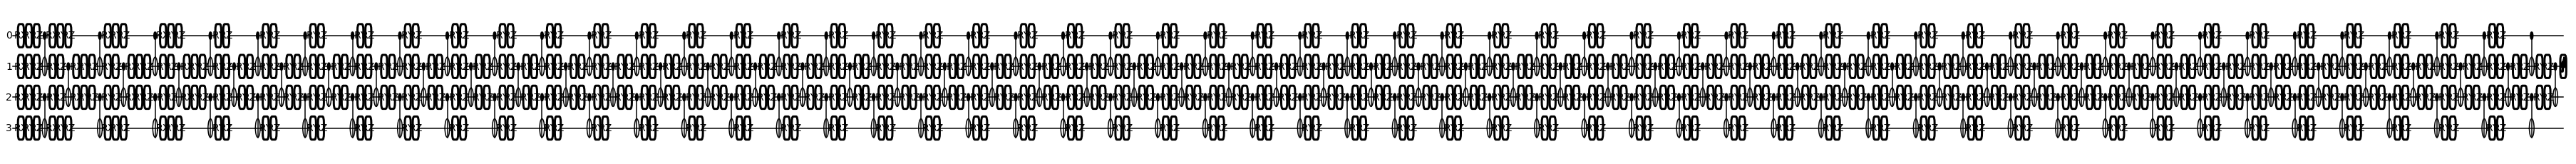

In [11]:
quantum_layer.draw(size=(50,3))

# Hybrid model

In [12]:
input_dim = input_data.size(1)

n_pre_classical_layers = 4
layers_dim = np.linspace(n_aminoacids, input_dim, 4).astype(int)

In [13]:
import torch.nn as nn
import torch
class ClippedReLU(nn.Module):
    def __init__(self, clip_val=2 * 3.141592653589793):
        super(ClippedReLU, self).__init__()
        self.clip_val = clip_val

    def forward(self, x):
        return torch.clamp(x, 0, self.clip_val).reshape(-1, n_aminoacids)

class Reshape(nn.Module):
    def __init__(self):
        super(Reshape, self).__init__()

    def forward(self, x):
        dims = len(x.shape)
        return torch.transpose(x, dims-2, dims-1).squeeze()

In [14]:
layers =  [ptm.nn.Embedding(num_embeddings=19, embedding_dim=1), Reshape()]
layers += [quantum_layer()]


In [15]:
# layers = []
# for i in range(1, len(layers_dim)):
#     layers += [ptm.nn.Linear(layers_dim[-1*i], layers_dim[-1*(i+1)]), ptm.nn.ReLU()]
# layers += [ptm.nn.Linear(layers_dim[0], layers_dim[0]), ClippedReLU()]
# layers += [quantum_layer()]
# # layers += [nn.Linear(1, 1)]
# # layers += [nn.Linear(2, 4), nn.ReLU()]
# # layers += [nn.Linear(4, 1)]

In [16]:
# Create model and set data:
model = ptm.pytorch_model(
    layers,    
    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [17]:
print(model(input_data[0:2]))
print(model(input_data[1]))

tensor([[-0.4278],
        [ 0.3097]], grad_fn=<ViewBackward>)
tensor([0.3097], grad_fn=<CatBackward>)


In [18]:
x = model.model[0](input_data[0:2])
print(x)

x = model.model[1](x)
print(x)

x = model.model[2](x)
print(x)

tensor([[[ 0.7240],
         [ 2.7281],
         [ 1.6571],
         [ 0.1932]],

        [[-0.7349],
         [-1.0556],
         [ 1.9118],
         [ 1.6571]]], grad_fn=<EmbeddingBackward>)
tensor([[ 0.7240,  2.7281,  1.6571,  0.1932],
        [-0.7349, -1.0556,  1.9118,  1.6571]], grad_fn=<SqueezeBackward0>)
tensor([[-0.4278],
        [ 0.3097]], grad_fn=<ViewBackward>)


In [19]:
model.keep_track_params=True,

In [20]:
import torch.optim as optim

# ask the user if he wants to start the training
out = input("Do you want to start the training? (y/n) ")
if out != 'y':
    sys.exit()

# train the model
model.train(
    optimizer= optim.SGD,
    optimizer_options={'lr': 0.5},
    num_epochs = 50,                
    batch_size = 32,
)

torch.Size([9000, 4]) torch.Size([9000, 1]) torch.Size([1000, 4]) torch.Size([1000, 1])
Epoch [0/50], Loss: 2.2732, Loss validation: 2.1121


/usr/lib/python3/dist-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(


	 Validation string, 	 i: 0; 	 prediction: -0.5240, 	 target: 0.1628, 	 loss: 4.2192
	 Validation string, 	 i: 1; 	 prediction: 0.0092, 	 target: 0.1942, 	 loss: 0.9528
	 Validation string, 	 i: 2; 	 prediction: 0.2096, 	 target: 0.1072, 	 loss: 0.9551
Epoch [1/50], Loss: 2.1922, Loss validation: 1.8319, Time remaining: ~1.0h 33.0m 16s
	 Validation string, 	 i: 0; 	 prediction: 0.1140, 	 target: 0.1628, 	 loss: 0.2999
	 Validation string, 	 i: 1; 	 prediction: 0.2195, 	 target: 0.1942, 	 loss: 0.1301
	 Validation string, 	 i: 2; 	 prediction: 0.1257, 	 target: 0.1072, 	 loss: 0.1720
Epoch [2/50], Loss: 2.1906, Loss validation: 1.8006, Time remaining: ~1.0h 26.0m 42s
	 Validation string, 	 i: 0; 	 prediction: -0.0378, 	 target: 0.1628, 	 loss: 1.2324
	 Validation string, 	 i: 1; 	 prediction: 0.0311, 	 target: 0.1942, 	 loss: 0.8401
	 Validation string, 	 i: 2; 	 prediction: -0.4392, 	 target: 0.1072, 	 loss: 5.0956
Epoch [3/50], Loss: 2.1839, Loss validation: 2.1082, Time remaining: ~1

In [ ]:
# save string of the model
model.save_str(
    metadata={
        "data_file_path": data_file_path,
    }
)

Saved in:  peptide-QML/checkpoints/0807/txts/0807-sh_e_1qm_model_str_7.txt


Saved in:  peptide-QML/checkpoints/0807/plots/0807-sh_e_1qm_losses_batches_9.png


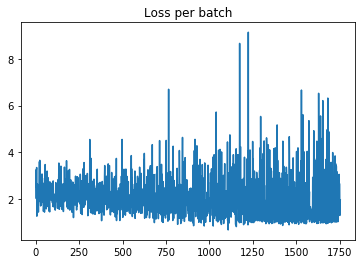

Saved in:  peptide-QML/checkpoints/0807/plots/0807-sh_e_1qm_losses_epoch_9.png


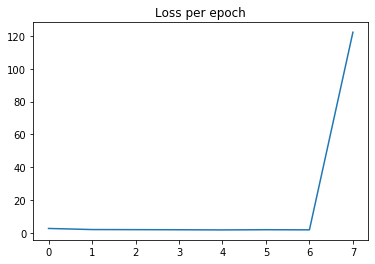

Saved in:  peptide-QML/checkpoints/0807/plots/0807-sh_e_1qm_losses_epoch_validation_9.png


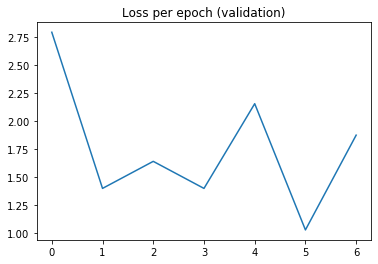

In [ ]:
# plot the losses of the trainig loop and save the figures
model.plot_losses(save=True)

Saved in:  peptide-QML/checkpoints/0807/plots/0807-sh_e_1qm_parameter_0.weight_None_9.png


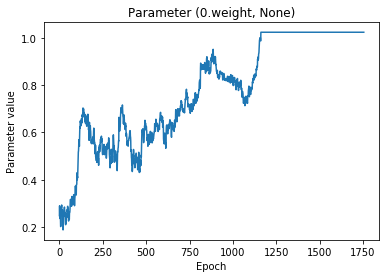

Saved in:  peptide-QML/checkpoints/0807/plots/0807-sh_e_1qm_parameter_2.embedding_weights_None_9.png


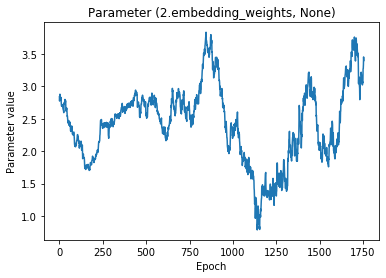

Saved in:  peptide-QML/checkpoints/0807/plots/0807-sh_e_1qm_parameter_2.block_weights_None_9.png


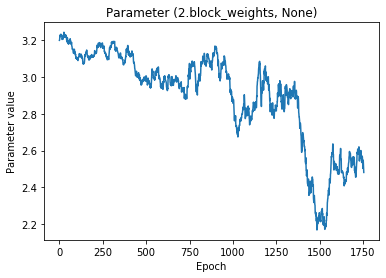

In [ ]:
# plot how the average of the parameters in each layer changes over time, and save that
for layer in model.model.state_dict().keys():
    model.plot_parameter(layer=layer, save=True)

In [ ]:
# model.plot_parameter(layer='7.weights', index=50)

In [ ]:
#save all the parameters of the model and the intermediate parameters of the model
model.save_state_dict(intermediate=True)

Model saved as peptide-QML/checkpoints/0807/models/0807-sh_e_1qm_7.pth and intermediate parameters saved in peptide-QML/checkpoints/0807/models/0807-sh_e_1qm_7


In [ ]:
# print validation and save it
model.print_validation(save=True, precision=4, percentatge=1)

i: 0, 		 target: -0.0693, 	 output: -0.3932, 	 loss: 4.6763
i: 1, 		 target: -0.0501, 	 output: -0.0311, 	 loss: 0.3784
i: 2, 		 target: -0.0773, 	 output: -0.3932, 	 loss: 4.0862
i: 3, 		 target: -0.0725, 	 output: -0.3932, 	 loss: 4.4209
i: 4, 		 target: 0.1070, 	 output: 0.0436, 	 loss: 0.5923
i: 5, 		 target: 0.0724, 	 output: -0.0411, 	 loss: 1.5682
i: 6, 		 target: 0.0418, 	 output: -0.3932, 	 loss: 10.4028
i: 7, 		 target: 0.1428, 	 output: 0.4254, 	 loss: 1.9787
i: 8, 		 target: 0.3083, 	 output: 0.2432, 	 loss: 0.2111
i: 9, 		 target: -0.0766, 	 output: -0.3932, 	 loss: 4.1348
i: 10, 		 target: 0.2309, 	 output: 0.3906, 	 loss: 0.6915
i: 11, 		 target: 0.1640, 	 output: 0.2432, 	 loss: 0.4826
i: 12, 		 target: -0.0722, 	 output: -0.3932, 	 loss: 4.4453
i: 13, 		 target: -0.0912, 	 output: -0.1434, 	 loss: 0.5726
i: 14, 		 target: -0.0382, 	 output: -0.3932, 	 loss: 9.2949
i: 15, 		 target: -0.0811, 	 output: -0.3932, 	 loss: 3.8490
i: 16, 		 target: 0.1750, 	 output: 0.2768, 	

In [ ]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push

Auto packing the repository in background for optimum performance.
See "git help gc" for manual housekeeping.
[main 93f88800] data trained model
 14111 files changed, 1038 insertions(+), 1 deletion(-)
 create mode 100644 checkpoints/0807/models/0807-sh_e_1qm_7.pth
 create mode 100644 checkpoints/0807/models/0807-sh_e_1qm_7/state_dict_00000.pth
 create mode 100644 checkpoints/0807/models/0807-sh_e_1qm_7/state_dict_00001.pth
 create mode 100644 checkpoints/0807/models/0807-sh_e_1qm_7/state_dict_00002.pth
 create mode 100644 checkpoints/0807/models/0807-sh_e_1qm_7/state_dict_00003.pth
 create mode 100644 checkpoints/0807/models/0807-sh_e_1qm_7/state_dict_00004.pth
 create mode 100644 checkpoints/0807/models/0807-sh_e_1qm_7/state_dict_00005.pth
 create mode 100644 checkpoints/0807/models/0807-sh_e_1qm_7/state_dict_00006.pth
 create mode 100644 checkpoints/0807/models/0807-sh_e_1qm_7/state_dict_00007.pth
 create mode 100644 checkpoints/0807/models/0807-sh_e_1qm_7/state_dict_00008.pth
 creat